In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-oct-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2022/train_9.csv
/kaggle/input/tabular-playground-series-oct-2022/train_3.csv
/kaggle/input/tabular-playground-series-oct-2022/train_4.csv
/kaggle/input/tabular-playground-series-oct-2022/test_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_8.csv
/kaggle/input/tabular-playground-series-oct-2022/train_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_5.csv
/kaggle/input/tabular-playground-series-oct-2022/train_2.csv
/kaggle/input/tabular-playground-series-oct-2022/test.csv
/kaggle/input/tabular-playground-series-oct-2022/train_0.csv
/kaggle/input/tabular-playground-series-oct-2022/train_7.csv
/kaggle/input/tabular-playground-series-oct-2022/train_1.csv
/kaggle/input/tabular-playground-series-oct-2022/train_6.csv


# Introduction
+ the kernel focuses on construct meaningful features
+ Thanks to the following kernels and discussions: [INFRARED](https://www.kaggle.com/code/infrarosso/tps-oct-2022-eda-hybrid-model-ensemble), [CHAZZER](https://www.kaggle.com/code/chazzer/rocket-league-xgboost-feat-engineering-cv)


# Modules

In [87]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold

In [41]:
train1 = pd.read_csv('/kaggle/input/tabular-playground-series-oct-2022/train_1.csv')

In [42]:
train1.columns

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

**The length and width of the pitch**

In [43]:
print(train1.nlargest(1, 'ball_pos_x')['ball_pos_x'])
print(train1.nsmallest(1, 'ball_pos_x')['ball_pos_x'])
print(train1.nlargest(1, 'ball_pos_y')['ball_pos_y'])
print(train1.nsmallest(1, 'ball_pos_y')['ball_pos_y'])
print(train1.nlargest(1, 'ball_pos_z')['ball_pos_z'])
print(train1.nsmallest(1, 'ball_pos_z')['ball_pos_z'])

720952    80.615204
Name: ball_pos_x, dtype: float64
326499   -80.6768
Name: ball_pos_x, dtype: float64
931369    104.309006
Name: ball_pos_y, dtype: float64
2165275   -104.3094
Name: ball_pos_y, dtype: float64
836656    39.4108
Name: ball_pos_z, dtype: float64
1489970    1.2858
Name: ball_pos_z, dtype: float64


# Feature Engineering

## Ideas on feature engineering
1. The feature can be divide into velocity data (x, y, z) and position data (x, y, z)
2. For position coordinates (x, y, z), the common solution is to construct new spatial features like distance feature (Manhattan, Euclidean, Minkowski distance).
3. Distance is a relative measurement depending on reference objectives (ball, gate, center spot of pitch).
4. Calculating players' distance to the ball will further shrink feature numbers.
5. velocity (x, y, z) is calculated as the absolute speed.
6. Team is defending or offending.
7. The distance between the ball and the gate.
8. boost advantage between teamA and teamB

## Euclidean Distance

In [44]:
def euclidean_dist(x):
    return np.linalg.norm(x, axis=1)

## Manhattan Distance

In [45]:
def manhattan_dist(x):
    dist = abs(x[0]) + abs(x[1]) + abs(x[2])
    return dist


## Minkowski Distance

In [46]:
distance.minkowski([1, 0, 0], [0, 9, 0], 5)

9.000030482951564

In [47]:
train1.columns

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

In [48]:
object_list = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'ball']
pos_dict = {f'{ob}_pos' :[f'{ob}_pos_x', f'{ob}_pos_y', f'{ob}_pos_z'] for ob in object_list}
vel_dict = {f'{ob}_vel' :[f'{ob}_vel_x', f'{ob}_vel_y', f'{ob}_vel_z'] for ob in object_list}
print(pos_dict, '\n')
print(vel_dict)

{'p0_pos': ['p0_pos_x', 'p0_pos_y', 'p0_pos_z'], 'p1_pos': ['p1_pos_x', 'p1_pos_y', 'p1_pos_z'], 'p2_pos': ['p2_pos_x', 'p2_pos_y', 'p2_pos_z'], 'p3_pos': ['p3_pos_x', 'p3_pos_y', 'p3_pos_z'], 'p4_pos': ['p4_pos_x', 'p4_pos_y', 'p4_pos_z'], 'p5_pos': ['p5_pos_x', 'p5_pos_y', 'p5_pos_z'], 'ball_pos': ['ball_pos_x', 'ball_pos_y', 'ball_pos_z']} 

{'p0_vel': ['p0_vel_x', 'p0_vel_y', 'p0_vel_z'], 'p1_vel': ['p1_vel_x', 'p1_vel_y', 'p1_vel_z'], 'p2_vel': ['p2_vel_x', 'p2_vel_y', 'p2_vel_z'], 'p3_vel': ['p3_vel_x', 'p3_vel_y', 'p3_vel_z'], 'p4_vel': ['p4_vel_x', 'p4_vel_y', 'p4_vel_z'], 'p5_vel': ['p5_vel_x', 'p5_vel_y', 'p5_vel_z'], 'ball_vel': ['ball_vel_x', 'ball_vel_y', 'ball_vel_z']}


In [49]:
for ob, col in vel_dict.items():
    temp = train1[col]
    train1[ob] = euclidean_dist(temp.values)

In [50]:
for ob, col in pos_dict.items():
    temp = train1[col]
    train1[ob] = euclidean_dist(temp.values)

## The distance between ball and gate

In [51]:
train1['gate_a_dist'] = euclidean_dist((train1[pos_dict['ball_pos']] - [0, 100, 20]).values)
train1['gate_b_dist'] = euclidean_dist((train1[pos_dict['ball_pos']] - [0, -100, 20]).values)

## The distance between players and gate

In [52]:
train1[f'team_a_defending'] = pd.Series(np.zeros(train1.shape[0]), index=train1.index)
train1[f'team_b_defending'] = pd.Series(np.zeros(train1.shape[0]), index=train1.index)

for player in range(3):
    train1[f'team_a_defending'] += ((train1[f'p{player}_pos_x']-0)**2 + (train1[f'p{player}_pos_y']+100)**2 + (train1[f'p{player}_pos_z']-20)**2)**0.5
    
for player in range(3, 6):
    train1[f'team_b_defending'] += ((train1[f'p{player}_pos_x']-0)**2 + (train1[f'p{player}_pos_y']-100)**2 + (train1[f'p{player}_pos_z']-20)**2)**0.5

## Team boost advantage
1. Team A advantage over team B on boost time.
2. Positive means team A has advantage.
3. Negative means team B has advantage.

In [53]:
train1['boost_A2B'] = train1['p0_boost'] + train1['p1_boost'] + train1['p2_boost'] - train1['p3_boost'] - train1['p4_boost'] - train1['p5_boost']

In [54]:
train1.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,p2_pos,p3_pos,p4_pos,p5_pos,ball_pos,gate_a_dist,gate_b_dist,team_a_defending,team_b_defending,boost_A2B
0,738,738001,-182.31840,-0.0,0.0,1.8548,-0.0,0.0,0.0,0.5200,...,63.734121,90.454939,75.189223,63.734121,1.8548,101.632909,101.632909,120.963649,120.843662,-7.105427e-15
1,738,738001,-182.21840,-0.0,0.0,1.8548,-0.0,0.0,0.0,1.2158,...,62.293624,89.244526,73.775842,62.294177,1.8548,101.632909,101.632909,122.653004,122.667263,0.000000e+00
2,738,738001,-182.11841,-0.0,0.0,1.8548,-0.0,0.0,0.0,1.9274,...,61.156481,88.080805,72.640790,61.145473,1.8548,101.632909,101.632909,123.990116,124.457999,5.200000e-01
3,738,738001,-182.01840,-0.0,0.0,1.8548,-0.0,0.0,0.0,2.9876,...,59.751228,87.299576,71.214930,59.697555,1.8548,101.632909,101.632909,125.880798,126.458254,-2.290000e+00
4,738,738001,-181.91840,-0.0,0.0,1.8548,-0.0,0.0,0.0,4.6502,...,57.104295,86.326447,69.374389,57.217586,1.8548,101.632909,101.632909,129.544363,129.118779,-4.754000e+00


In [60]:
col2drop = ['game_num', 'event_id', 'event_time', 
            'ball_pos_x', 'ball_pos_y','ball_pos_z', 
            'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 
            'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 
            'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 
            'p0_boost',
            'p1_pos_x', 'p1_pos_y', 'p1_pos_z',
            'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
            'p1_boost', 
            'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 
            'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 
            'p2_boost', 
            'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 
            'p3_vel_x','p3_vel_y', 'p3_vel_z', 
            'p3_boost', 
            'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
            'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 
            'p4_boost', 
            'p5_pos_x', 'p5_pos_y','p5_pos_z', 
            'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 
            'p5_boost', 
            'boost0_timer', 'boost1_timer', 'boost2_timer', 
            'boost3_timer', 'boost4_timer', 'boost5_timer', 
            'player_scoring_next',
            'team_scoring_next']

In [61]:
train1 = train1.drop(columns=col2drop)

In [62]:
train1.head()

,team_A_scoring_within_10sec,team_B_scoring_within_10sec,p0_vel,p1_vel,p2_vel,p3_vel,p4_vel,p5_vel,ball_vel,p0_pos,...,p2_pos,p3_pos,p4_pos,p5_pos,ball_pos,gate_a_dist,gate_b_dist,team_a_defending,team_b_defending,boost_A2B
0,0,0,12.096422,12.458553,12.458232,12.096319,12.264508,12.458232,0.0,90.454939,...,63.734121,90.454939,75.189223,63.734121,1.8548,101.632909,101.632909,120.963649,120.843662,-7.105427e-15
1,0,0,15.615963,17.178336,16.173174,15.616077,16.003731,16.063877,0.0,89.244526,...,62.293624,89.244526,73.775842,62.294177,1.8548,101.632909,101.632909,122.653004,122.667263,0.000000e+00
2,0,0,17.701257,27.203084,19.208352,18.434388,18.290774,18.151077,0.0,88.393467,...,61.156481,88.080805,72.640790,61.145473,1.8548,101.632909,101.632909,123.990116,124.457999,5.200000e-01
3,0,0,19.828590,28.357029,21.129611,20.273513,19.870367,21.155726,0.0,87.485489,...,59.751228,87.299576,71.214930,59.697555,1.8548,101.632909,101.632909,125.880798,126.458254,-2.290000e+00
4,0,0,22.166509,29.644452,31.065847,23.777699,21.579347,32.200414,0.0,86.574249,...,57.104295,86.326447,69.374389,57.217586,1.8548,101.632909,101.632909,129.544363,129.118779,-4.754000e+00


In [72]:
# how many rows removed due to NA
print(f'{train1.shape[0]-train1.dropna().shape[0]} rows are removed due to presence of NA values')

114876 rows are removed due to presence of NA values


In [73]:
train1 = train1.dropna()

## Correlation Heatmap

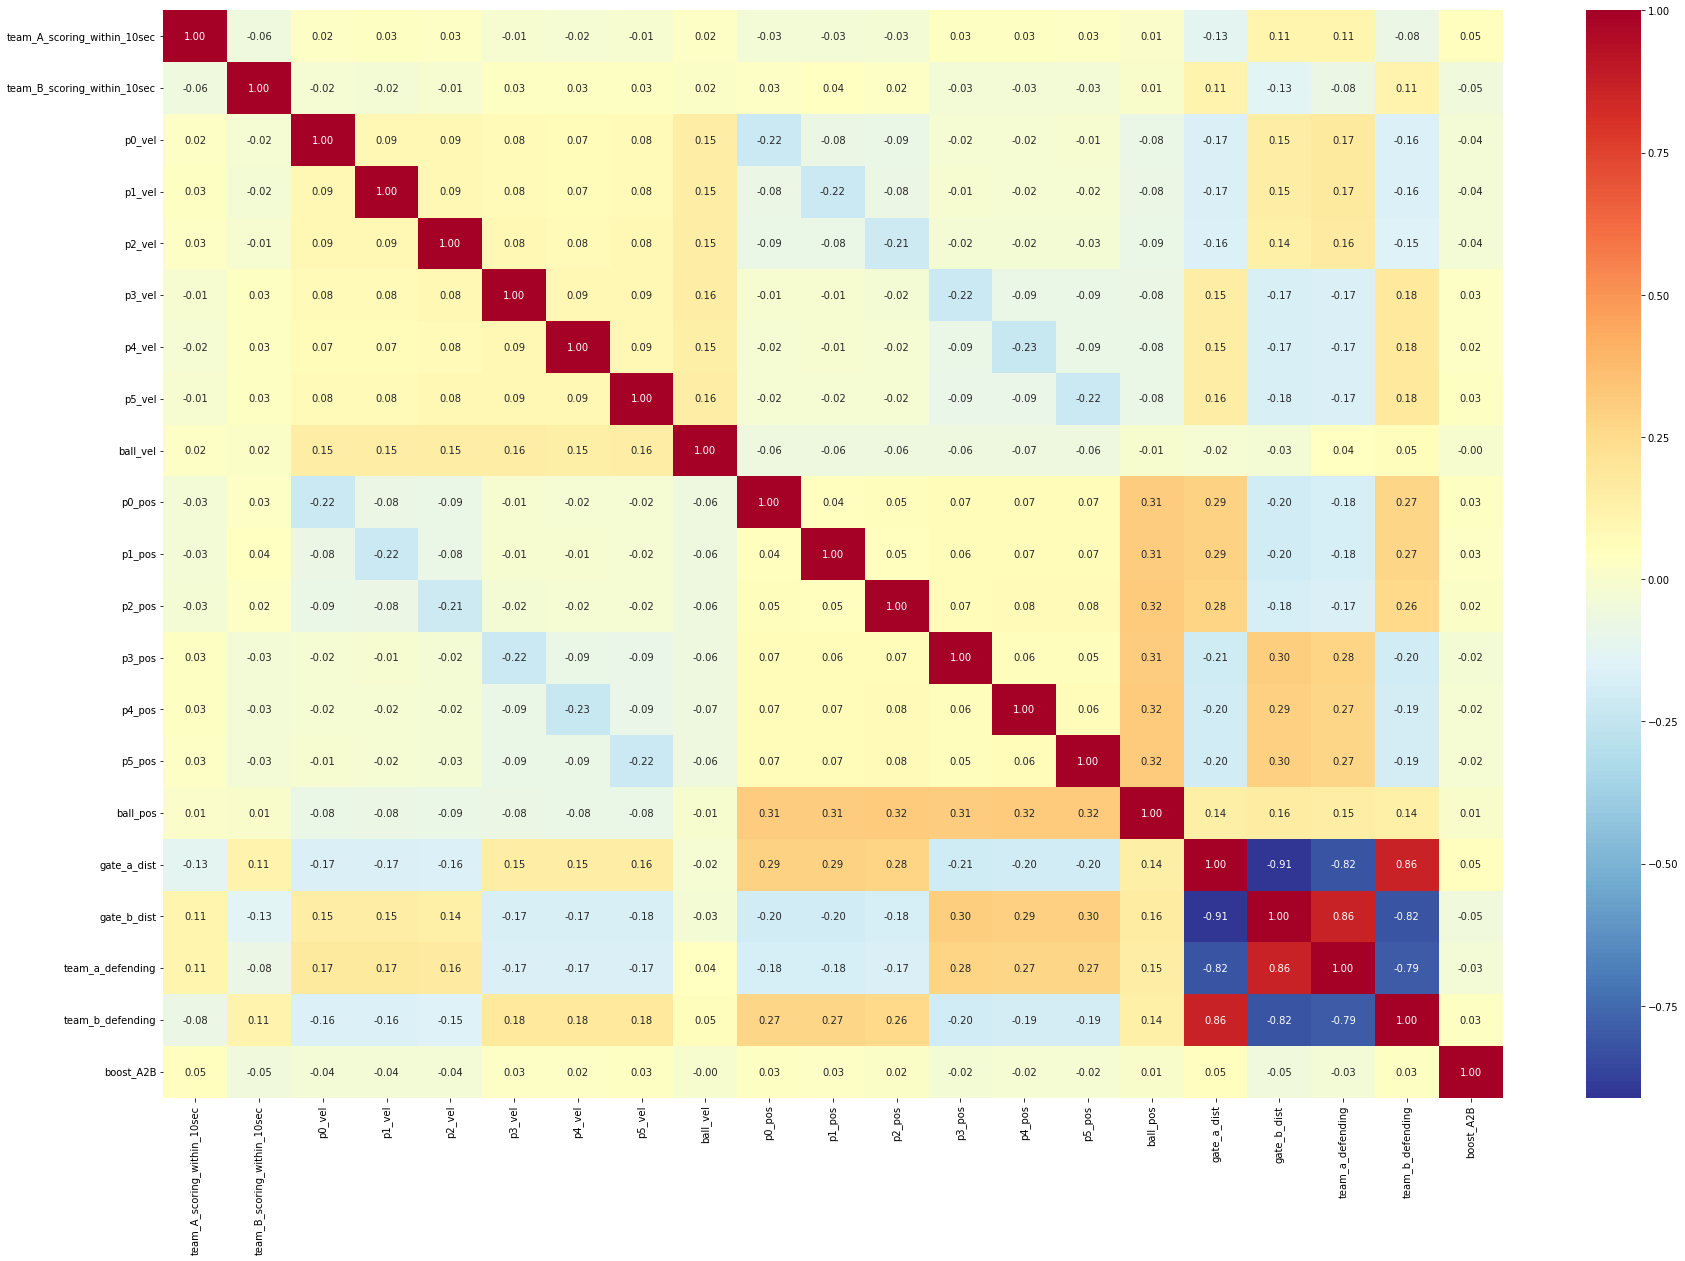

In [83]:
cor_matrix = train1.corr()
plt.figure(figsize=(30,20))
sns.heatmap(cor_matrix, cmap='RdYlBu_r', annot=True, fmt='.2f')
plt.show()

## Model training
1. to apply several basic supervised models.
2. to practice cross validation.